In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re  # For regular expressions

# --- Data Collection & Exploration ---
# Load the dataset
try:
    df = pd.read_csv(r"C:\Users\INDIA\Downloads\NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv' not found. Please ensure the file path is correct.")
    exit()

Dataset loaded successfully.


In [16]:
# Inspect the dataset structure
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDataset Description (Numerical Columns):")
print(df.describe())

# Identify missing values
print("\nMissing Values (Count):")
print(df.isnull().sum())

# Identify duplicate records
print("\nNumber of Duplicate Records:")
print(df.duplicated().sum())

# Remove duplicate records if any
df.drop_duplicates(inplace=True)
print(f"Duplicates removed. New shape: {df.shape}")


Dataset Head:
  show_id     type  title           director                                               cast        country         date_added  release_year rating   duration                                          listed_in                                        description
0      s1  TV Show     3%                NaN  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil    August 14, 2020          2020  TV-MA  4 Seasons  International TV Shows, TV Dramas, TV Sci-Fi &...  In a future where the elite inhabit an island ...
1      s2    Movie   7:19  Jorge Michel Grau  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico  December 23, 2016          2016  TV-MA     93 min                       Dramas, International Movies  After a devastating earthquake hits Mexico Cit...
2      s3    Movie  23:59       Gilbert Chan  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore  December 20, 2018          2011      R     78 min                Horror Movies, I

C:\Users\INDIA\AppData\Local\Temp\ipykernel_10288\787052983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, palette='viridis')


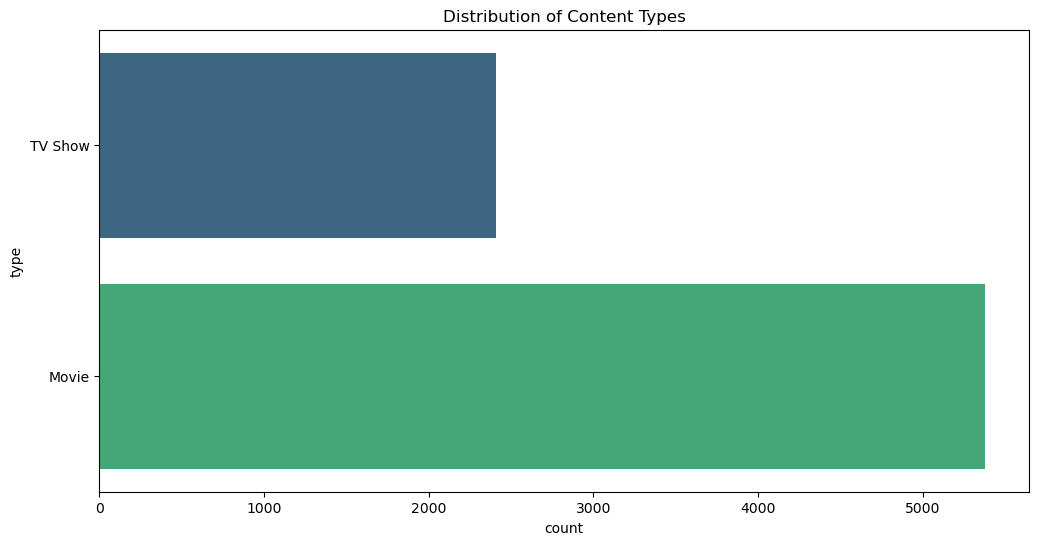

C:\Users\INDIA\AppData\Local\Temp\ipykernel_10288\787052983.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='magma')


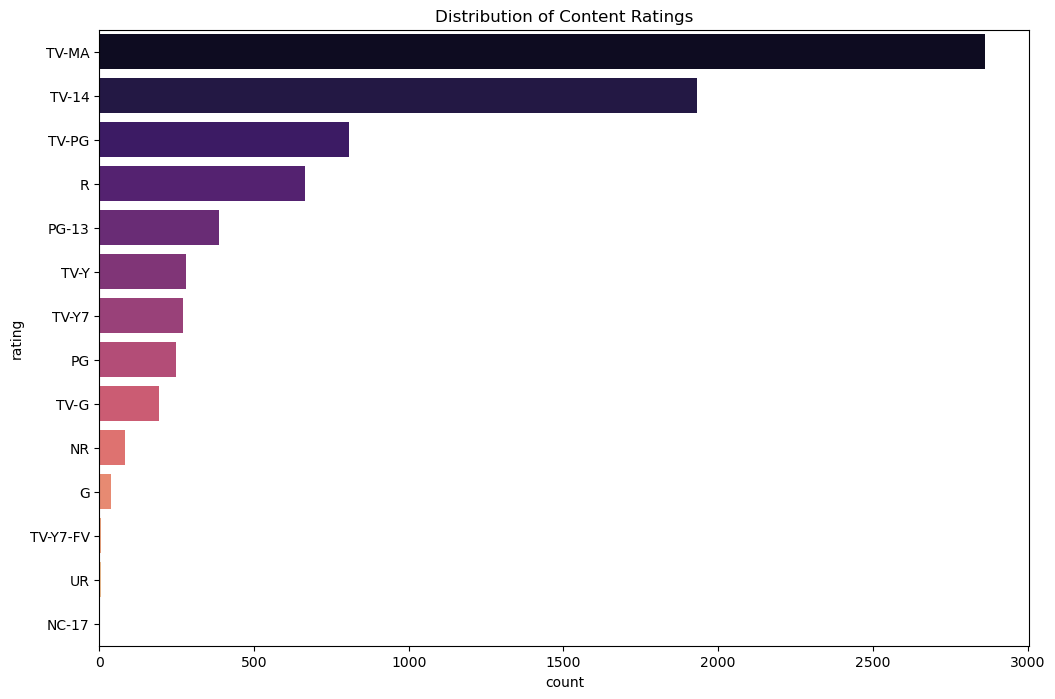

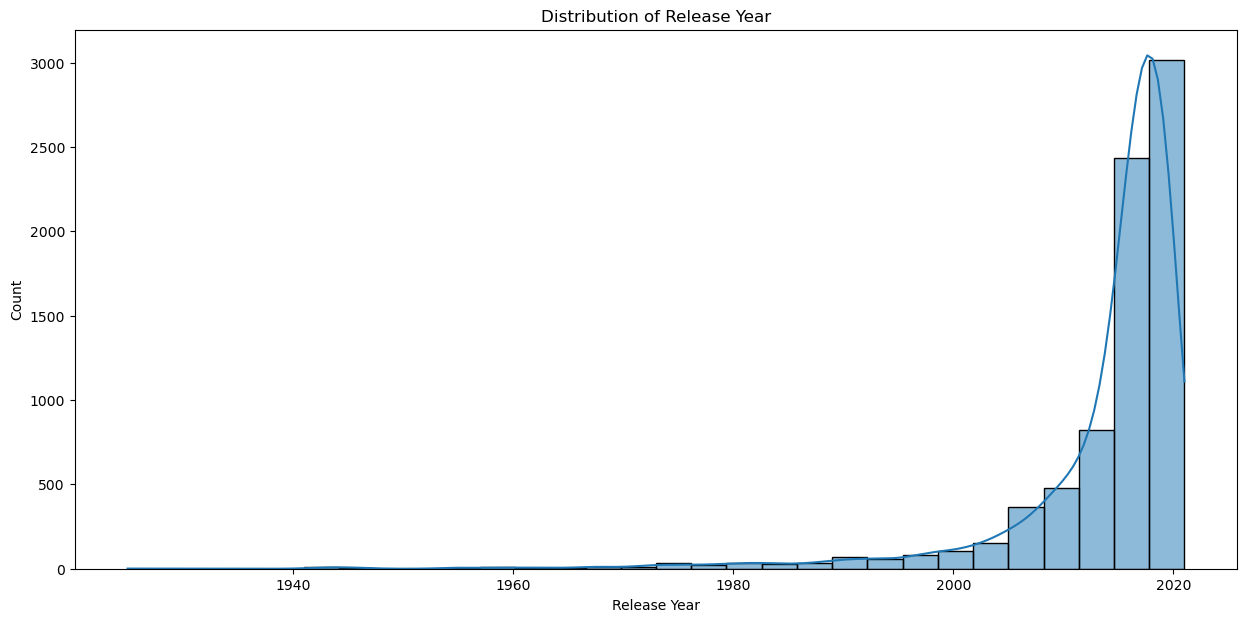

In [17]:
# Perform Exploratory Data Analysis (EDA) - Basic Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(y='type', data=df, palette='viridis')
plt.title('Distribution of Content Types')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='magma')
plt.title('Distribution of Content Ratings')
plt.show()

plt.figure(figsize=(15, 7))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title('Distribution of Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

In [18]:
# --- Data Preprocessing ---
# Handle missing values
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)

# For 'rating', fill with the mode if there are still missing values
if df['rating'].isnull().any():
    mode_rating = df['rating'].mode()[0]
    df['rating'].fillna(mode_rating, inplace=True)

# For 'duration', fill missing values with 0 min
df['duration'].fillna('0 min', inplace=True)

# Convert duration to numerical (min for movies, season for TV shows)
def convert_duration(duration):
    if 'min' in duration:
        return int(re.findall(r'\d+', duration)[0])
    elif 'Season' in duration:
        return int(re.findall(r'\d+', duration)[0]) * 100  
    return 0

df['duration_numeric'] = df['duration'].apply(convert_duration)
print("\n'duration' converted to 'duration_numeric'.")
print(df[['duration', 'duration_numeric']].head())

# Convert categorical data to numerical format
# 'type' (binary: Movie/TV Show) -> Label Encoding
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
print("\n'type' encoded to 'type_encoded'.")
print(df[['type', 'type_encoded']].head())

# 'rating' -> One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
rating_encoded = ohe.fit_transform(df[['rating']])
rating_df = pd.DataFrame(rating_encoded, columns=ohe.get_feature_names_out(['rating']), index=df.index)
df = pd.concat([df, rating_df], axis=1)
print("\n'rating' one-hot encoded.")
print(df[[col for col in df.columns if 'rating_' in str(col)]].head())

# 'country' - group top 10 countries and others as 'Other'
top_countries = df['country'].value_counts().nlargest(10).index.tolist()
df['country_grouped'] = df['country'].apply(lambda x: x if x in top_countries else 'Other')

ohe_country = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
country_encoded = ohe_country.fit_transform(df[['country_grouped']])
country_df = pd.DataFrame(country_encoded, columns=ohe_country.get_feature_names_out(['country_grouped']), index=df.index)
df = pd.concat([df, country_df], axis=1)
print("\n'country' grouped and one-hot encoded.")
print(df[[col for col in df.columns if 'country_grouped_' in str(col)]].head())

Filled missing 'rating' with mode: TV-MA

'duration' converted to 'duration_numeric'.
    duration  duration_numeric
0  4 Seasons               400
1     93 min                93
2     78 min                78
3     80 min                80
4    123 min               123

'type' encoded to 'type_encoded'.
      type  type_encoded
0  TV Show             1
1    Movie             0
2    Movie             0
3    Movie             0
4    Movie             0

'rating' one-hot encoded.
   rating_G  rating_NC-17  rating_NR  rating_PG  rating_PG-13  rating_R  rating_TV-14  rating_TV-G  rating_TV-MA  rating_TV-PG  rating_TV-Y  rating_TV-Y7  rating_TV-Y7-FV  rating_UR
0       0.0           0.0        0.0        0.0           0.0       0.0           0.0          0.0           1.0           0.0          0.0           0.0              0.0        0.0
1       0.0           0.0        0.0        0.0           0.0       0.0           0.0          0.0           1.0           0.0          0.0           0.

C:\Users\INDIA\AppData\Local\Temp\ipykernel_10288\2342893614.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
C:\Users\INDIA\AppData\Local\Temp\ipykernel_10288\2342893614.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [19]:
# Standardize numerical features: 'duration_numeric', 'release_year'
scaler = StandardScaler()
df['duration_scaled'] = scaler.fit_transform(df[['duration_numeric']])
df['release_year_scaled'] = scaler.fit_transform(df[['release_year']])
print("\nNumerical features scaled.")
print(df[['duration_numeric', 'duration_scaled', 'release_year', 'release_year_scaled']].head())

# Extract relevant features from text columns using NLP (TF-IDF)
df['text_features'] = df['listed_in'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['cast'].fillna('') + ' ' + df['director'].fillna('')

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features to avoid sparsity issues
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_features'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df.index)
df = pd.concat([df, tfidf_df], axis=1)
print(f"\nTF-IDF features extracted. Shape: {tfidf_df.shape}")


Numerical features scaled.
   duration_numeric  duration_scaled  release_year  release_year_scaled
0               400         2.799086          2020             0.692878
1                93        -0.309171          2016             0.236092
2                78        -0.461040          2011            -0.334890
3                80        -0.440791          2009            -0.563284
4               123        -0.005432          2008            -0.677480

TF-IDF features extracted. Shape: (7787, 5000)


In [20]:
# --- Feature Engineering ---
# Content age: current_year - release_year
current_year = pd.to_datetime('today').year
df['content_age'] = current_year - df['release_year']
print("\n'content_age' created.")
print(df[['release_year', 'content_age']].head())

# Genre count: Number of genres associated with each content.
df['genre_count'] = df['listed_in'].apply(lambda x: len(x.split(', ')) if pd.notna(x) else 0)
print("\n'genre_count' created.")
print(df[['listed_in', 'genre_count']].head())

# Standardize newly created numerical features
df['content_age_scaled'] = scaler.fit_transform(df[['content_age']])
df['genre_count_scaled'] = scaler.fit_transform(df[['genre_count']])
print("\nNewly created numerical features scaled.")
print(df[['content_age', 'content_age_scaled', 'genre_count', 'genre_count_scaled']].head())

# Select features for clustering
features_for_clustering = [
    'type_encoded',
    'duration_scaled',
    'release_year_scaled',
    'content_age_scaled',
    'genre_count_scaled'
] + [col for col in df.columns if 'rating_' in str(col)] + \
  [col for col in df.columns if 'country_grouped_' in str(col)]  # Exclude TF-IDF features for now

# Ensure all selected columns exist and handle potential NaNs if any slipped through
X = df[features_for_clustering].copy()
X.fillna(0, inplace=True)  # Fill any remaining NaNs with 0


'content_age' created.
   release_year  content_age
0          2020            5
1          2016            9
2          2011           14
3          2009           16
4          2008           17

'genre_count' created.
                                           listed_in  genre_count
0  International TV Shows, TV Dramas, TV Sci-Fi &...            3
1                       Dramas, International Movies            2
2                Horror Movies, International Movies            2
3  Action & Adventure, Independent Movies, Sci-Fi...            3
4                                             Dramas            1

Newly created numerical features scaled.
   content_age  content_age_scaled  genre_count  genre_count_scaled
0            5           -0.692878            3            1.027634
1            9           -0.236092            2           -0.244574
2           14            0.334890            2           -0.244574
3           16            0.563284            3            1.027634



Features selected for clustering. Shape: (7787, 30)


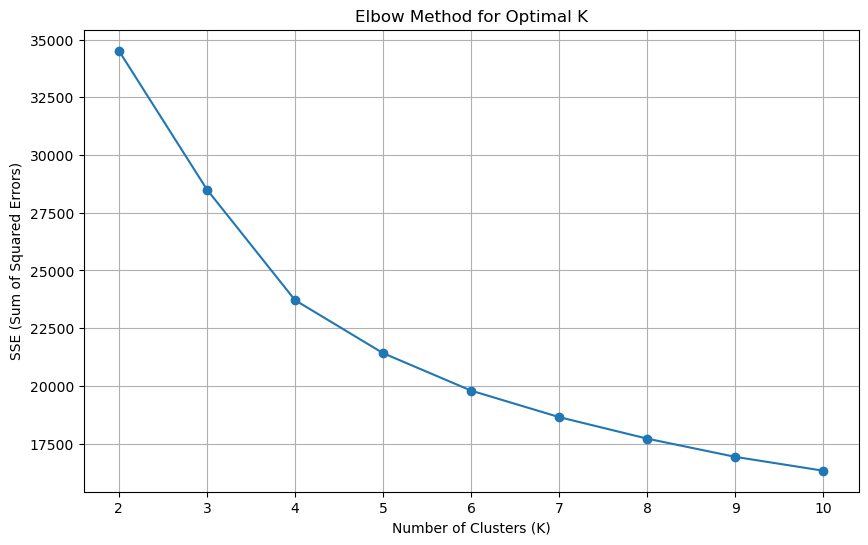

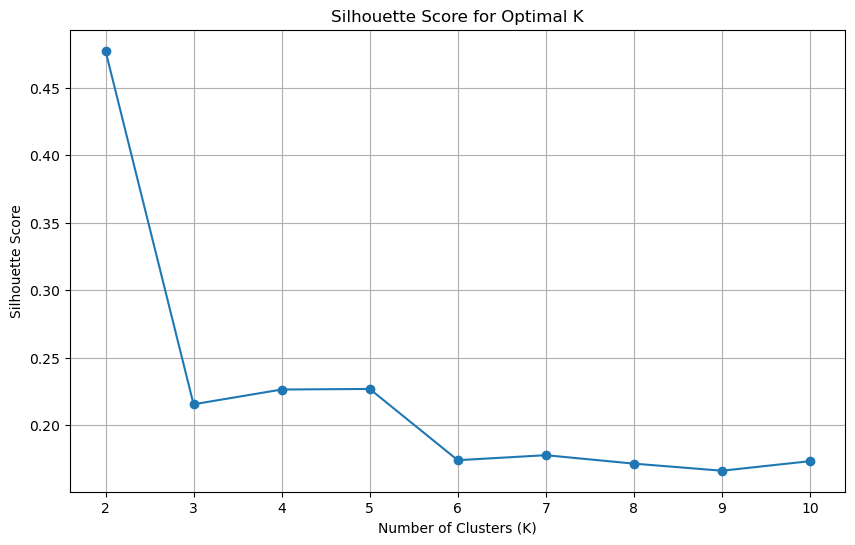

In [21]:
# Ensure all features are numeric
if not np.issubdtype(X.values.dtype, np.number):
    print("Error: Non-numeric data found in features for clustering.")
    # Optionally, you can convert or drop non-numeric columns here
else:
    print(f"\nFeatures selected for clustering. Shape: {X.shape}")
    # --- Clustering Model Selection & Training ---
    # Determine optimal number of clusters for K-Means using Elbow Method and Silhouette Score
    sse = []
    k_range = range(2, 11)  # Test K from 2 to 10
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        try:
            kmeans.fit(X)
            sse.append(kmeans.inertia_)
        except ValueError as e:
            print(f"ValueError for K={k}: {e}")
            sse.append(np.nan)  # Append NaN if fitting fails
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    try:
        cluster_labels = kmeans.fit_predict(X)
        if len(np.unique(cluster_labels)) > 1:  # Silhouette score requires more than 1 cluster
            score = silhouette_score(X, cluster_labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Indicate invalid score
    except ValueError as e:
        print(f"ValueError for K={k}: {e}")
        silhouette_scores.append(np.nan)  # Append NaN if fitting fails

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [22]:
# Based on the plots, choose an optimal K (e.g., 4 or 5, this is subjective and depends on the data)
optimal_k = 5  # Example: Let's assume 5 based on typical elbow/silhouette patterns

# K-Means Clustering
print(f"\nApplying K-Means with optimal_k = {optimal_k}")
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans_model.fit_predict(X)
print("K-Means clustering complete.")
print(df['kmeans_cluster'].value_counts().sort_index())

# Hierarchical Clustering
print("\nApplying Hierarchical Clustering (AgglomerativeClustering)")
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward', metric='euclidean')
df['agg_cluster'] = agg_clustering.fit_predict(X)
print("Hierarchical clustering complete.")
print(df['agg_cluster'].value_counts().sort_index())

# DBSCAN
print("\nApplying DBSCAN (with example parameters)")
dbscan = DBSCAN(eps=0.5, min_samples=5)  # These parameters need tuning for your specific data
df['dbscan_cluster'] = dbscan.fit_predict(X)
print("DBSCAN clustering complete.")
print(df['dbscan_cluster'].value_counts().sort_index())


Applying K-Means with optimal_k = 5
K-Means clustering complete.
kmeans_cluster
0     232
1    2770
2     213
3    3690
4     882
Name: count, dtype: int64

Applying Hierarchical Clustering (AgglomerativeClustering)
Hierarchical clustering complete.
agg_cluster
0    5356
1     625
2     165
3    1475
4     166
Name: count, dtype: int64

Applying DBSCAN (with example parameters)
DBSCAN clustering complete.
dbscan_cluster
-1      1258
 0         6
 1       254
 2        98
 3        46
        ... 
 205       5
 206       5
 207       5
 208       5
 209       6
Name: count, Length: 211, dtype: int64


In [23]:
# --- Model Training & Optimization (Dimensionality Reduction for Visualization) ---
# PCA for 2D visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)
df['pca_1'] = X_pca_2d[:, 0]
df['pca_2'] = X_pca_2d[:, 1]
print("\nPCA for 2D visualization complete.")

# t-SNE for 2D visualization
print("\nApplying t-SNE for 2D visualization (this may take a while)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)  # Adjust perplexity and n_iter as needed
X_tsne = tsne.fit_transform(X)
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]
print("t-SNE for 2D visualization complete.")


PCA for 2D visualization complete.

Applying t-SNE for 2D visualization (this may take a while)...


C:\Users\INDIA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE for 2D visualization complete.


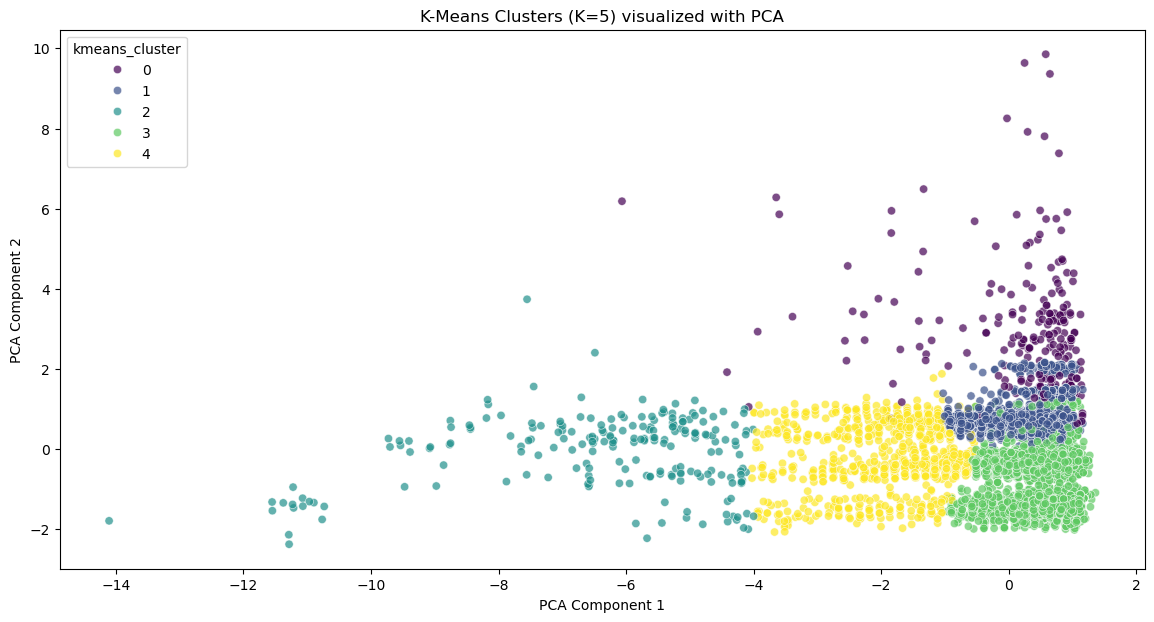


Most Common Genres per K-Means Cluster:

Cluster 0:
listed_in
TV Comedies               86
TV Dramas                 81
International TV Shows    47
Kids' TV                  46
Crime TV Shows            37
Name: count, dtype: int64

Cluster 1:
listed_in
International Movies      1281
Dramas                    1075
International TV Shows     866
Comedies                   669
Independent Movies         462
Name: count, dtype: int64

Cluster 2:
listed_in
Dramas                  99
International Movies    91
Classic Movies          84
Action & Adventure      55
Comedies                53
Name: count, dtype: int64

Cluster 3:
listed_in
International Movies        739
Documentaries               644
Dramas                      603
Comedies                    444
Children & Family Movies    339
Name: count, dtype: int64

Cluster 4:
listed_in
Dramas                  329
International Movies    326
Comedies                305
Action & Adventure      177
Romantic Movies         103
Name: coun

In [24]:
# --- Visualization & Interpretation ---
# Cluster plots (using PCA for K-Means clusters)
plt.figure(figsize=(14, 7))
sns.scatterplot(x='pca_1', y='pca_2', hue='kmeans_cluster', data=df, palette='viridis', legend='full', alpha=0.7)
plt.title(f'K-Means Clusters (K={optimal_k}) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Interpretation: Most common genres per group (for K-Means)
print("\nMost Common Genres per K-Means Cluster:")
for cluster_id in sorted(df['kmeans_cluster'].unique()):
    cluster_data = df[df['kmeans_cluster'] == cluster_id]
    genres = cluster_data['listed_in'].str.split(', ').explode().value_counts().nlargest(5)
    print(f"\nCluster {cluster_id}:")
    print(genres)

In [25]:
# --- Evaluation & Refinement ---
# Evaluate K-Means
kmeans_silhouette = silhouette_score(X, df['kmeans_cluster'])
kmeans_davies_bouldin = davies_bouldin_score(X, df['kmeans_cluster'])
kmeans_inertia = kmeans_model.inertia_
print(f"\nK-Means Evaluation (K={optimal_k}):")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")
print(f"  Inertia (SSE): {kmeans_inertia:.2f}")

# Evaluate Hierarchical Clustering
agg_labels = df['agg_cluster']
agg_silhouette = silhouette_score(X, agg_labels)
agg_davies_bouldin = davies_bouldin_score(X, agg_labels)
print(f"\nHierarchical Clustering Evaluation (K={optimal_k}):")
print(f"  Silhouette Score: {agg_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {agg_davies_bouldin:.4f}")

# Evaluate DBSCAN
dbscan_labels = df['dbscan_cluster']
core_samples_mask = dbscan_labels != -1
if np.sum(core_samples_mask) > 1 and len(np.unique(dbscan_labels[core_samples_mask])) > 1:
    dbscan_silhouette = silhouette_score(X[core_samples_mask], dbscan_labels[core_samples_mask])
    dbscan_davies_bouldin = davies_bouldin_score(X[core_samples_mask], dbscan_labels[core_samples_mask])
    print(f"\nDBSCAN Evaluation:")
    print(f"  Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")
    print(f"  Davies-Bouldin Index (excluding noise): {dbscan_davies_bouldin:.4f}")
else:
    print("\nDBSCAN: Not enough non-noise clusters for Silhouette/Davies-Bouldin score.")

print("\n--- End of Analysis ---")



K-Means Evaluation (K=5):
  Silhouette Score: 0.2269
  Davies-Bouldin Index: 1.2675
  Inertia (SSE): 21417.24

Hierarchical Clustering Evaluation (K=5):
  Silhouette Score: 0.1977
  Davies-Bouldin Index: 1.2233

DBSCAN Evaluation:
  Silhouette Score (excluding noise): 0.5040
  Davies-Bouldin Index (excluding noise): 0.6922

--- End of Analysis ---
